In [1]:
# %matplotlib widget


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from keras import optimizers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import matplotlib.pyplot as plt

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    return X_

def load_Y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    return y_

/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-

In [3]:
def euclidean_dist(a, b):
    # This function calculates the euclidean distance between 2 point in 2-D coordinates
    # if one of two points is (0,0), dist = 0
    # a, b: input array with dimension: m, 2
    # m: number of samples
    # 2: x and y coordinate
    try:
        if (a.shape[1] == 2 and a.shape == b.shape):
            # check if element of a and b is (0,0)
            bol_a = (a[:,0] != 0).astype(int)
            bol_b = (b[:,0] != 0).astype(int)
            dist = np.linalg.norm(a-b, axis=1)
            return((dist*bol_a*bol_b).reshape(a.shape[0],1))
    except:
        print("[Error]: Check dimension of input vector")
        return 0

In [4]:
def norm_X(X):
    num_sample = X.shape[0]
    # Keypoints
    Nose = X[:,0*2:0*2+2]
    Neck = X[:,1*2:1*2+2]
    RShoulder = X[:,2*2:2*2+2]
    RElbow = X[:,3*2:3*2+2]
    RWrist = X[:,4*2:4*2+2]
    LShoulder = X[:,5*2:5*2+2]
    LElbow = X[:,6*2:6*2+2]
    LWrist = X[:,7*2:7*2+2]
    RHip = X[:,8*2:8*2+2]
    RKnee = X[:,9*2:9*2+2]
    RAnkle = X[:,10*2:10*2+2]
    LHip = X[:,11*2:11*2+2]
    LKnee = X[:,12*2:12*2+2]
    LAnkle = X[:,13*2:13*2+2]
    REye = X[:,14*2:14*2+2]
    LEye = X[:,15*2:15*2+2]
    REar = X[:,16*2:16*2+2]
    LEar = X[:,17*2:17*2+2]

    # Length of head
    length_Neck_LEar = euclidean_dist(Neck, LEar)
    length_Neck_REar = euclidean_dist(Neck, REar)
    length_Neck_LEye = euclidean_dist(Neck, LEye)
    length_Neck_REye = euclidean_dist(Neck, REye)
    length_Nose_LEar = euclidean_dist(Nose, LEar)
    length_Nose_REar = euclidean_dist(Nose, REar)
    length_Nose_LEye = euclidean_dist(Nose, LEye)
    length_Nose_REye = euclidean_dist(Nose, REye)
    length_head      = np.maximum.reduce([length_Neck_LEar, length_Neck_REar, length_Neck_LEye, length_Neck_REye, \
                                 length_Nose_LEar, length_Nose_REar, length_Nose_LEye, length_Nose_REye])
    #length_head      = np.sqrt(np.square((LEye[:,0:1]+REye[:,0:1])/2 - Neck[:,0:1]) + np.square((LEye[:,1:2]+REye[:,1:2])/2 - Neck[:,1:2]))

    # Length of torso
    length_Neck_LHip = euclidean_dist(Neck, LHip)
    length_Neck_RHip = euclidean_dist(Neck, RHip)
    length_torso     = np.maximum(length_Neck_LHip, length_Neck_RHip)
    #length_torso     = np.sqrt(np.square(Neck[:,0:1]-(LHip[:,0:1]+RHip[:,0:1])/2) + np.square(Neck[:,1:2]-(LHip[:,1:2]+RHip[:,1:2])/2))

    # Length of right leg
    length_leg_right = euclidean_dist(RHip, RKnee) + euclidean_dist(RKnee, RAnkle)
    #length_leg_right = np.sqrt(np.square(RHip[:,0:1]-RKnee[:,0:1]) + np.square(RHip[:,1:2]-RKnee[:,1:2])) \
    #+ np.sqrt(np.square(RKnee[:,0:1]-RAnkle[:,0:1]) + np.square(RKnee[:,1:2]-RAnkle[:,1:2]))

    # Length of left leg
    length_leg_left = euclidean_dist(LHip, LKnee) + euclidean_dist(LKnee, LAnkle)
    #length_leg_left = np.sqrt(np.square(LHip[:,0:1]-LKnee[:,0:1]) + np.square(LHip[:,1:2]-LKnee[:,1:2])) \
    #+ np.sqrt(np.square(LKnee[:,0:1]-LAnkle[:,0:1]) + np.square(LKnee[:,1:2]-LAnkle[:,1:2]))

    # Length of leg
    length_leg = np.maximum(length_leg_right, length_leg_left)

    # Length of body
    length_body = length_head + length_torso + length_leg
    
    # Check all samples have length_body of 0
    length_chk = (length_body > 0).astype(int)
    
    # Check keypoints at origin
    keypoints_chk = (X > 0).astype(int)
    
    chk = length_chk * keypoints_chk
    
    # Set all length_body of 0 to 1 (to avoid division by 0)
    length_body[length_body == 0] = 1
    
    # The center of gravity
    # number of point OpenPose locates:
    num_pts = (X[:, 0::2] > 0).sum(1).reshape(num_sample,1)
    centr_x = X[:, 0::2].sum(1).reshape(num_sample,1) / num_pts
    centr_y = X[:, 1::2].sum(1).reshape(num_sample,1) / num_pts

    # The  coordinates  are  normalized relative to the length of the body and the center of gravity
    X_norm_x = (X[:, 0::2] - centr_x) / length_body
    X_norm_y = (X[:, 1::2] - centr_y) / length_body
    
    # Stack 1st element x and y together
    X_norm = np.column_stack((X_norm_x[:,:1], X_norm_y[:,:1]))
        
    for i in range(1, X.shape[1]//2):
        X_norm = np.column_stack((X_norm, X_norm_x[:,i:i+1], X_norm_y[:,i:i+1]))
    
    # Set all samples have length_body of 0 to origin (0, 0)
    X_norm = X_norm * chk
    
    return X_norm

In [5]:
def plot_line(a, b):
    if (a.any()> 0 and b.any()>0): plt.plot([a[0], b[0]], [a[1], b[1]], 'k-')
        
def plot_skeleton(sample, pattern):
    for i in range(len(sample)//2):
        plt.plot(sample[i*2], sample[i*2+1], pattern) 
    skeleton = sample.reshape(1, 36)
    Nose = skeleton[:,0*2:0*2+2][0]
    Neck = skeleton[:,1*2:1*2+2][0]
    RShoulder = skeleton[:,2*2:2*2+2][0]
    RElbow = skeleton[:,3*2:3*2+2][0]
    RWrist = skeleton[:,4*2:4*2+2][0]
    LShoulder = skeleton[:,5*2:5*2+2][0]
    LElbow = skeleton[:,6*2:6*2+2][0]
    LWrist = skeleton[:,7*2:7*2+2][0]
    RHip = skeleton[:,8*2:8*2+2][0]
    RKnee = skeleton[:,9*2:9*2+2][0]
    RAnkle = skeleton[:,10*2:10*2+2][0]
    LHip = skeleton[:,11*2:11*2+2][0]
    LKnee = skeleton[:,12*2:12*2+2][0]
    LAnkle = skeleton[:,13*2:13*2+2][0]
    REye = skeleton[:,14*2:14*2+2][0]
    LEye = skeleton[:,15*2:15*2+2][0]
    REar = skeleton[:,16*2:16*2+2][0]
    LEar = skeleton[:,17*2:17*2+2][0]
    #Nose = sample.reshape(1, 36)[:,0*2:0*2+2][0]
    #Neck = sample.reshape(1, 36)[:,1*2:1*2+2][0]
    plot_line(LEar, LEye)
    plot_line(LEye, Nose)
    plot_line(REar, REye)
    plot_line(REye, Nose)
    plot_line(Nose, Neck)
    plot_line(Neck, LShoulder)
    plot_line(LShoulder, LElbow)
    plot_line(LElbow, LWrist)
    plot_line(Neck, RShoulder)
    plot_line(RShoulder, RElbow)
    plot_line(RElbow, RWrist)
    plot_line(Neck, LHip)
    plot_line(LHip, LKnee)
    plot_line(LKnee, LAnkle)
    plot_line(Neck, RHip)
    plot_line(RHip, RKnee)
    plot_line(RKnee, RAnkle)
    
def plot(sample):
    # sample is one-dimension array
    # e.g: (36,)
    if sample.shape[0] == 36:
        sample_norm = norm_X(sample.reshape(1,36))[0]

        # Plot original coordinates
        pad_ori = 40
        plt.figure(str(sample))
        plt.subplot(121)
        plt.title('Original skeleton')
        X_ori = sample
        x_max = max(X_ori[0::2]) + pad_ori
        x_min = min(i for i in X_ori[0::2] if i > 0) - pad_ori
        y_max = max(X_ori[1::2]) + pad_ori
        y_min = min(j for j in X_ori[1::2] if j > 0) - pad_ori
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton(X_ori, 'bo')

        # Plot normalized coordinates
        pad_nor = 0.2
        #plt.figure(2)
        plt.subplot(122)
        plt.title('Normalized skeleton')
        X_nor = sample_norm
        x_max = max(X_nor[0::2]) + pad_nor
        x_min = min(X_nor[0::2]) - pad_nor
        y_max = max(X_nor[1::2]) + pad_nor
        y_min = min(X_nor[1::2]) - pad_nor
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton(X_nor, 'ro')
    else:
        print("sample is one-dimension array: (36,)")

In [6]:
# Create a model
model = keras.Sequential([
    keras.layers.Dense(64, activation='sigmoid', input_shape=(36,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.summary()

# plot training log
def plot_history(history):
    history_dict = history.history
    history_dict.keys()
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'ro', label='Validation loss')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation loss/acc')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2368      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
____

In [7]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=['accuracy'])

In [8]:
# Load and norminalize dataset
X_train = load_X('dataset/X_train.txt')
Y_train = load_Y('dataset/Y_train.txt')
X_train_norm = norm_X(X_train)

X_test = load_X('dataset/X_test.txt')
Y_test = load_Y('dataset/Y_test.txt')
X_test_norm = norm_X(X_test)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/X_train.txt'

In [9]:
history = model.fit(X_train_norm, Y_train, validation_data=(X_test_norm, Y_test), epochs=500, batch_size=32, verbose=1)#, callbacks= [earlyStopping])

NameError: name 'X_train_norm' is not defined

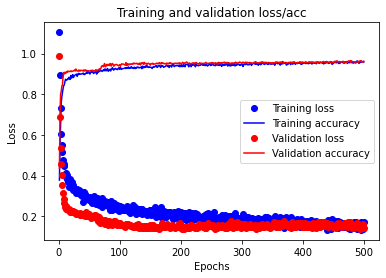

In [21]:
plot_history(history)

In [22]:
# save model 
model.save('pose_classifier.h5')

Estimated pose:
STANDING: 	0.05383162
BENDING: 	0.013991522
CROUCHING: 	0.9321768


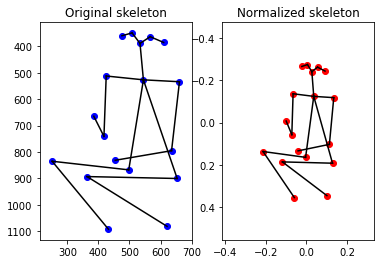

In [23]:
# Testing on single example
LABELS = ["STANDING", "BENDING", "CROUCHING"]

X_sample = load_X('dataset/X_sample.txt')
X_sample_norm = norm_X(X_sample)
y_out = model.predict(X_sample_norm[0].reshape(1, 36))

print("Estimated pose:")
for idx in range(len(LABELS)):
    print(LABELS[idx] + ": \t" + str(y_out[0][idx]))
plot(X_sample[0])


In [24]:
X_sample[0]

array([ 533.882  ,  388.70547,  544.8678 ,  526.60767,  425.08575,
        512.1124 ,  417.78983,  740.82495,  385.09637,  664.53375,
        660.9374 ,  533.8324 ,  635.50964,  795.03125,  454.12094,
        831.36127,  497.63477,  867.6868 ,  250.93797,  835.04785,
        432.3186 , 1092.6522 ,  653.5648 ,  900.40186,  363.2616 ,
        893.10504,  621.06165, 1081.7125 ,  508.40002,  348.8913 ,
        566.73413,  363.1943 ,  475.6909 ,  359.54095,  610.0567 ,
        385.11093], dtype=float32)

In [25]:
X_sample_norm[0]

array([ 0.02696206, -0.24112062,  0.03626795, -0.12430575, -0.06519762,
       -0.13658445, -0.07137789,  0.0571545 , -0.09907202, -0.00747063,
        0.13458875, -0.11818579,  0.1130493 ,  0.10307184, -0.04060235,
        0.13384645, -0.00374244,  0.16461729, -0.21271559,  0.1369693 ,
       -0.05907078,  0.3551821 ,  0.12834357,  0.1923297 , -0.11756794,
        0.18614868,  0.10081062,  0.34591525,  0.00537665, -0.27484662,
        0.05479059, -0.26273075, -0.02233077, -0.26582545,  0.09148849,
       -0.24416551])

In [26]:
X_train.shape

(2676, 36)

In [27]:
X_train_norm

array([[-0.06378927, -0.32805909,  0.04035647, ..., -0.        ,
         0.02647038, -0.30028689],
       [-0.16565792, -0.24813442,  0.01409855, ..., -0.32215179,
        -0.10221446, -0.27985615],
       [-0.1786875 , -0.25772235,  0.01718149, ..., -0.31957571,
        -0.09621634, -0.26803124],
       ...,
       [ 0.09145509, -0.20297831, -0.04005403, ..., -0.2595356 ,
        -0.        , -0.        ],
       [-0.09871121, -0.16568105,  0.09543595, ..., -0.        ,
        -0.02479915, -0.31357428],
       [-0.18946615, -0.18003524,  0.02389214, ..., -0.        ,
        -0.10412145, -0.29637347]])

## Load and Normalize Alpha Pose

In [10]:
index_alphapose={
    # Use 17 skeleton point
    "Nose": 0,
    #"Neck": "-",
    "RShoulder": 6,
    "RElbow": 8,
    "RWrist": 10,
    "LShoulder": 5,
    "LElbow": 7,
    "LWrist": 9,
    "RHip": 12,
    "RKnee": 14,
    "RAnkle": 16,
    "LHip": 11,
    "LKnee": 13,
    "LAnkle": 15,
    "REye": 2,
    "LEye": 1,
    "REar": 4,
    "LEar": 3
}


In [11]:
def data_converter(data):
    data=data['keypoints']
    keypoints=[]
    kp_score=[]
    for a in range (0,len(data)):
        score=[]
        if ((a+3)%3==0):
            keypoints.append(data[a])
            keypoints.append(data[a+1])
        elif((a+1)%3==0):
            score=[data[a]]
            kp_score.append(score)

    return keypoints
    
    
def euclidean_dist(a, b):
    # This function calculates the euclidean distance between 2 point in 2-D coordinates
    # if one of two points is (0,0), dist = 0
    # a, b: input array with dimension: m, 2
    # m: number of samples
    # 2: x and y coordinate
    try:
        if (a.shape[1] == 2 and a.shape == b.shape):
            # check if element of a and b is (0,0)
            bol_a = (a[:,0] != 0).astype(int)
            bol_b = (b[:,0] != 0).astype(int)
            dist = np.linalg.norm(a-b, axis=1)
            return((dist*bol_a*bol_b).reshape(a.shape[0],1))
    except:
        print("[Error]: Check dimension of input vector")
        return 0


# Function to find next in alpha pose because alpha pose did not have neck

def find_neck(alpha_example):
    
    # 10 and 11 is x and y coordinate for left shoulder of alpha pose
    x1= alpha_example[:,10] 
    y1= alpha_example[:,11]
    
    
    # 12 and 13 is x and y coordinate for right shoulder of alpha pose
    x2= alpha_example[:,12]
    y2= alpha_example[:,13]
    
    # Result will be  neck coordinate(array([586.35131836, 472.55082703]), array([559.9307251 , 480.63751221])) ((x1,x2),(y1,y2))
    neck_= ((x1 + x2)/2, (y1 + y2)/2)
    
    result_neck=[]
    for a,b in zip(neck_[0],neck_[1]):
        result_neck.append([a,b])
    
    neck=np.asarray(result_neck)
    return neck

def norm_alpha(X):
    num_sample = X.shape[0]
    # Keypoints
    Nose = X[:,index_alphapose['Nose']*2:index_alphapose['Nose']*2+2]
    Neck = find_neck(X)
    RShoulder = X[:,index_alphapose['RShoulder']*2:index_alphapose['RShoulder']*2+2]
    RElbow = X[:,index_alphapose['RElbow']*2:index_alphapose['RElbow']*2+2]
    RWrist = X[:,index_alphapose['RWrist']*2:index_alphapose['RWrist']*2+2]
    LShoulder = X[:,index_alphapose['LShoulder']*2:index_alphapose['LShoulder']*2+2]
    LElbow = X[:,index_alphapose['LElbow']*2:index_alphapose['LElbow']*2+2]
    LWrist = X[:,index_alphapose['LWrist']*2:index_alphapose['LWrist']*2+2]
    RHip = X[:,index_alphapose['RHip']*2:index_alphapose['RHip']*2+2]
    RKnee = X[:,index_alphapose['RKnee']*2:index_alphapose['RKnee']*2+2]
    RAnkle = X[:,index_alphapose['RAnkle']*2:index_alphapose['RAnkle']*2+2]
    LHip = X[:,index_alphapose['LHip']*2:index_alphapose['LHip']*2+2]
    LKnee = X[:,index_alphapose['LKnee']*2:index_alphapose['LKnee']*2+2]
    LAnkle = X[:,index_alphapose['LAnkle']*2:index_alphapose['LAnkle']*2+2]
    REye = X[:,index_alphapose['REye']*2:index_alphapose['REye']*2+2]
    LEye = X[:,index_alphapose['LEye']*2:index_alphapose['LEye']*2+2]
    REar = X[:,index_alphapose['REar']*2:index_alphapose['REar']*2+2]
    LEar = X[:,index_alphapose['LEar']*2:index_alphapose['LEar']*2+2]

    # Length of head
    length_Neck_LEar = euclidean_dist(Neck, LEar)
    length_Neck_REar = euclidean_dist(Neck, REar)
    length_Neck_LEye = euclidean_dist(Neck, LEye)
    length_Neck_REye = euclidean_dist(Neck, REye)
    length_Nose_LEar = euclidean_dist(Nose, LEar)
    length_Nose_REar = euclidean_dist(Nose, REar)
    length_Nose_LEye = euclidean_dist(Nose, LEye)
    length_Nose_REye = euclidean_dist(Nose, REye)
    length_head      = np.maximum.reduce([length_Neck_LEar, length_Neck_REar, length_Neck_LEye, length_Neck_REye, \
                                 length_Nose_LEar, length_Nose_REar, length_Nose_LEye, length_Nose_REye])

    # Length of torso
    length_Neck_LHip = euclidean_dist(Neck, LHip)
    length_Neck_RHip = euclidean_dist(Neck, RHip)
    length_torso     = np.maximum(length_Neck_LHip, length_Neck_RHip)
    #length_torso     = np.sqrt(np.square(Neck[:,0:1]-(LHip[:,0:1]+RHip[:,0:1])/2) + np.square(Neck[:,1:2]-(LHip[:,1:2]+RHip[:,1:2])/2))

    # Length of right leg
    length_leg_right = euclidean_dist(RHip, RKnee) + euclidean_dist(RKnee, RAnkle)
  

    # Length of left leg
    length_leg_left = euclidean_dist(LHip, LKnee) + euclidean_dist(LKnee, LAnkle)
 

    # Length of leg
    length_leg = np.maximum(length_leg_right, length_leg_left)

    # Length of body
    length_body = length_head + length_torso + length_leg
    
    # Check all samples have length_body of 0
    length_chk = (length_body > 0).astype(int)
    
    # Check keypoints at origin
    keypoints_chk = (X > 0).astype(int)
    
    chk = length_chk * keypoints_chk
    
    # Set all length_body of 0 to 1 (to avoid division by 0)
    length_body[length_body == 0] = 1
    
    # The center of gravity
    # number of point OpenPose locates:
    num_pts = (X[:, 0::2] > 0).sum(1).reshape(num_sample,1)
    centr_x = X[:, 0::2].sum(1).reshape(num_sample,1) / num_pts

    centr_y = X[:, 1::2].sum(1).reshape(num_sample,1) / num_pts


    # The  coordinates  are  normalized relative to the length of the body and the center of gravity
    X_norm_x = (X[:, 0::2] - centr_x) / length_body
    X_norm_y = (X[:, 1::2] - centr_y) / length_body
    
    # Stack 1st element x and y together
    X_norm = np.column_stack((X_norm_x[:,:1], X_norm_y[:,:1]))
        
    for i in range(1, X.shape[1]//2):
        X_norm = np.column_stack((X_norm, X_norm_x[:,i:i+1], X_norm_y[:,i:i+1]))
    
    # Set all samples have length_body of 0 to origin (0, 0)
    X_norm = X_norm * chk
    
    return X_norm

def find_neck_plot(alpha_example):
    
    # 10 and 11 is x and y coordinate for left shoulder of alpha pose
    x1= alpha_example[:,10] 
    y1= alpha_example[:,11]
    
    
    # 12 and 13 is x and y coordinate for right shoulder of alpha pose
    x2= alpha_example[:,12]
    y2= alpha_example[:,13]

    neck_= [float((x1 + x2)/2), float((y1 + y2)/2)]
    neck_=np.asarray(neck_)

    return neck_

def plot_line(a, b):
    if (a.any()> 0 and b.any()>0): plt.plot([a[0], b[0]], [a[1], b[1]], 'k-')
        
def plot_skeleton_alpha(sample, pattern):
    for i in range(len(sample)//2):
        plt.plot(sample[i*2], sample[i*2+1], pattern) 
    skeleton = sample.reshape(1, 34)
    Nose = skeleton[:,index_alphapose['Nose']*2:index_alphapose['Nose']*2+2][0]

    Neck = find_neck_plot(skeleton)

    RShoulder = skeleton[:,index_alphapose['RShoulder']*2:index_alphapose['RShoulder']*2+2][0]
    RElbow = skeleton[:,index_alphapose['RElbow']*2:index_alphapose['RElbow']*2+2][0]
    RWrist = skeleton[:,index_alphapose['RWrist']*2:index_alphapose['RWrist']*2+2][0]
    LShoulder = skeleton[:,index_alphapose['LShoulder']*2:index_alphapose['LShoulder']*2+2][0]
    LElbow = skeleton[:,index_alphapose['LElbow']*2:index_alphapose['LElbow']*2+2][0]
    LWrist = skeleton[:,index_alphapose['LWrist']*2:index_alphapose['LWrist']*2+2][0]
    RHip = skeleton[:,index_alphapose['RHip']*2:index_alphapose['RHip']*2+2][0]
    RKnee = skeleton[:,index_alphapose['RKnee']*2:index_alphapose['RKnee']*2+2][0]
    RAnkle = skeleton[:,index_alphapose['RAnkle']*2:index_alphapose['RAnkle']*2+2][0]
    LHip = skeleton[:,index_alphapose['LHip']*2:index_alphapose['LHip']*2+2][0]
    LKnee = skeleton[:,index_alphapose['LKnee']*2:index_alphapose['LKnee']*2+2][0]
    LAnkle = skeleton[:,index_alphapose['LAnkle']*2:index_alphapose['LAnkle']*2+2][0]
    REye = skeleton[:,index_alphapose['REye']*2:index_alphapose['REye']*2+2][0]
    LEye = skeleton[:,index_alphapose['LEye']*2:index_alphapose['LEye']*2+2][0]
    REar = skeleton[:,index_alphapose['REar']*2:index_alphapose['REar']*2+2][0]
    LEar = skeleton[:,index_alphapose['LEar']*2:index_alphapose['LEar']*2+2][0]
    #Nose = sample.reshape(1, 36)[:,0*2:0*2+2][0]
    #Neck = sample.reshape(1, 36)[:,1*2:1*2+2][0]
    plot_line(LEar, LEye)
    plot_line(LEye, Nose)
    plot_line(REar, REye)
    plot_line(REye, Nose)
    plot_line(Nose, Neck)
    plot_line(Neck, LShoulder)
    plot_line(LShoulder, LElbow)
    plot_line(LElbow, LWrist)
    plot_line(Neck, RShoulder)
    plot_line(RShoulder, RElbow)
    plot_line(RElbow, RWrist)
    plot_line(Neck, LHip)
    plot_line(LHip, LKnee)
    plot_line(LKnee, LAnkle)
    plot_line(Neck, RHip)
    plot_line(RHip, RKnee)
    plot_line(RKnee, RAnkle)
    
def plot_alpha(sample):
    # sample is one-dimension array
    # e.g: (34,)
    if sample.shape[0] == 34:
        sample_norm = norm_alpha(sample.reshape(1,34))[0]

        # Plot original coordinates
        pad_ori = 40
        plt.figure(str(sample))
        plt.subplot(121)
        plt.title('Original skeleton')
        X_ori = sample
        x_max = max(X_ori[0::2]) + pad_ori
        x_min = min(i for i in X_ori[0::2] if i > 0) - pad_ori
        y_max = max(X_ori[1::2]) + pad_ori
        y_min = min(j for j in X_ori[1::2] if j > 0) - pad_ori
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton_alpha(X_ori, 'bo')

        # Plot normalized coordinates
        pad_nor = 0.2
        #plt.figure(2)
        plt.subplot(122)
        plt.title('Normalized skeleton')
        X_nor = sample_norm
        x_max = max(X_nor[0::2]) + pad_nor
        x_min = min(X_nor[0::2]) - pad_nor
        y_max = max(X_nor[1::2]) + pad_nor
        y_min = min(X_nor[1::2]) - pad_nor
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton_alpha(X_nor, 'ro')
    else:
        print("sample is one-dimension array: (36,)")

In [1]:
import json 
import numpy as np
import torch

# Opening JSON file 
f = open('alphapose-results.json',) 
  
# returns JSON object as  
# a dictionary 
data = json.load(f) 
  

# Closing file 
f.close() 

In [2]:
alpha_example=np.asarray(data_converter(data[150]))
alpha_example = np.append(alpha_example,data_converter(data[150]))
alpha_example = alpha_example.reshape(2, 34)

NameError: name 'data_converter' is not defined

In [ ]:
alpha_example.shape

In [3]:
alpha_example

NameError: name 'alpha_example' is not defined

In [16]:
alpha_norm=norm_alpha(alpha_example)

In [17]:
alpha_norm.shape

(2, 34)

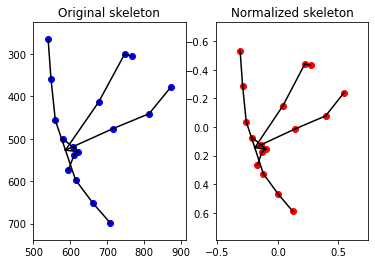

In [18]:
# Testing on single example

plot_alpha(alpha_example[0])


## Load and Normalize Human Eva

<img src="img/humanevaskeleton.png" >

In [19]:
import matplotlib.pyplot as plt

In [20]:

index_humaneva={
    # Use 15 skeleton point
    "Pelvis": 0,
    "Head": 14,
    "Thorax":1,
    "RShoulder": 5,
    "RElbow": 6,
    "RWrist": 7,
    "LShoulder": 2,
    "LElbow": 3,
    "LWrist": 4,
    "RHip": 11,
    "RKnee": 12,
    "RAnkle": 13,
    "LHip": 8,
    "LKnee": 9,
    "LAnkle": 10,
}

def euclidean_dist(a, b):
    # This function calculates the euclidean distance between 2 point in 2-D coordinates
    # if one of two points is (0,0), dist = 0
    # a, b: input array with dimension: m, 2
    # m: number of samples
    # 2: x and y coordinate
    try:
        if (a.shape[1] == 2 and a.shape == b.shape):
            # check if element of a and b is (0,0)
            bol_a = (a[:,0] != 0).astype(int)
            bol_b = (b[:,0] != 0).astype(int)
            dist = np.linalg.norm(a-b, axis=1)
            return((dist*bol_a*bol_b).reshape(a.shape[0],1))
    except:
        print("[Error]: Check dimension of input vector")
        return 0


def norm_humaneva(X):
    num_sample = X.shape[0]
    # Keypoints
    Pelvis = X[:,index_humaneva['Pelvis']*2:index_humaneva['Pelvis']*2+2]
    Head = X[:,index_humaneva['Head']*2:index_humaneva['Head']*2+2]
    Thorax = X[:,index_humaneva['Thorax']*2:index_humaneva['Thorax']*2+2]
    RShoulder = X[:,index_humaneva['RShoulder']*2:index_humaneva['RShoulder']*2+2]
    RElbow = X[:,index_humaneva['RElbow']*2:index_humaneva['RElbow']*2+2]
    RWrist = X[:,index_humaneva['RWrist']*2:index_humaneva['RWrist']*2+2]
    LShoulder = X[:,index_humaneva['LShoulder']*2:index_humaneva['LShoulder']*2+2]
    LElbow = X[:,index_humaneva['LElbow']*2:index_humaneva['LElbow']*2+2]
    LWrist = X[:,index_humaneva['LWrist']*2:index_humaneva['LWrist']*2+2]
    RHip = X[:,index_humaneva['RHip']*2:index_humaneva['RHip']*2+2]
    RKnee = X[:,index_humaneva['RKnee']*2:index_humaneva['RKnee']*2+2]
    RAnkle = X[:,index_humaneva['RAnkle']*2:index_humaneva['RAnkle']*2+2]
    LHip = X[:,index_humaneva['LHip']*2:index_humaneva['LHip']*2+2]
    LKnee = X[:,index_humaneva['LKnee']*2:index_humaneva['LKnee']*2+2]
    LAnkle = X[:,index_humaneva['LAnkle']*2:index_humaneva['LAnkle']*2+2]


    # Length of head
    length_Head_Thorax = euclidean_dist(Head, Thorax)
    length_head      = np.maximum.reduce([length_Head_Thorax])

    # Length of torso
    length_Thorax_LHip = euclidean_dist(Thorax, LHip)
    length_Thorax_RHip = euclidean_dist(Thorax, RHip)
    length_torso     = np.maximum(length_Thorax_LHip, length_Thorax_RHip)

    # Length of right leg
    length_leg_right = euclidean_dist(RHip, RKnee) + euclidean_dist(RKnee, RAnkle)
  
    # Length of left leg
    length_leg_left = euclidean_dist(LHip, LKnee) + euclidean_dist(LKnee, LAnkle)


    # Length of leg
    length_leg = np.maximum(length_leg_right, length_leg_left)

    # Length of body
    length_body = length_head + length_torso + length_leg
    
    # Check all samples have length_body of 0
    length_chk = (length_body > 0).astype(int)
    
    # Check keypoints at origin
    keypoints_chk = (X > 0).astype(int)
    
    chk = length_chk * keypoints_chk
    
    # Set all length_body of 0 to 1 (to avoid division by 0)
    length_body[length_body == 0] = 1
    
    # The center of gravity
    # number of point OpenPose locates:
    num_pts = (X[:, 0::2] > 0).sum(1).reshape(num_sample,1)
    centr_x = X[:, 0::2].sum(1).reshape(num_sample,1) / num_pts
    centr_y = X[:, 1::2].sum(1).reshape(num_sample,1) / num_pts

    # The  coordinates  are  normalized relative to the length of the body and the center of gravity
    X_norm_x = (X[:, 0::2] - centr_x) / length_body
    X_norm_y = (X[:, 1::2] - centr_y) / length_body
    
    # Stack 1st element x and y together
    X_norm = np.column_stack((X_norm_x[:,:1], X_norm_y[:,:1]))
        
    for i in range(1, X.shape[1]//2):
        X_norm = np.column_stack((X_norm, X_norm_x[:,i:i+1], X_norm_y[:,i:i+1]))
    
    # Set all samples have length_body of 0 to origin (0, 0)
    X_norm = X_norm * chk
    
    return X_norm

In [139]:
def plot_line(a, b):
    if (a.any()> 0 and b.any()>0): plt.plot([a[0], b[0]], [a[1], b[1]], 'k-')
        
def plot_skeleton_humaneva(sample, pattern):
    for i in range(len(sample)//2):
        plt.plot(sample[i*2], sample[i*2+1], pattern) 
    skeleton = sample.reshape(1, 30)
    # Keypoints
    Pelvis = skeleton[:,index_humaneva['Pelvis']*2:index_humaneva['Pelvis']*2+2][0]
    Head = skeleton[:,index_humaneva['Head']*2:index_humaneva['Head']*2+2][0]
    Thorax = skeleton[:,index_humaneva['Thorax']*2:index_humaneva['Thorax']*2+2][0]
    RShoulder = skeleton[:,index_humaneva['RShoulder']*2:index_humaneva['RShoulder']*2+2][0]
    RElbow = skeleton[:,index_humaneva['RElbow']*2:index_humaneva['RElbow']*2+2][0]
    RWrist = skeleton[:,index_humaneva['RWrist']*2:index_humaneva['RWrist']*2+2][0]
    LShoulder = skeleton[:,index_humaneva['LShoulder']*2:index_humaneva['LShoulder']*2+2][0]
    LElbow = skeleton[:,index_humaneva['LElbow']*2:index_humaneva['LElbow']*2+2][0]
    LWrist = skeleton[:,index_humaneva['LWrist']*2:index_humaneva['LWrist']*2+2][0]
    RHip = skeleton[:,index_humaneva['RHip']*2:index_humaneva['RHip']*2+2][0]
    RKnee = skeleton[:,index_humaneva['RKnee']*2:index_humaneva['RKnee']*2+2][0]
    RAnkle = skeleton[:,index_humaneva['RAnkle']*2:index_humaneva['RAnkle']*2+2][0]
    LHip = skeleton[:,index_humaneva['LHip']*2:index_humaneva['LHip']*2+2][0]
    LKnee = skeleton[:,index_humaneva['LKnee']*2:index_humaneva['LKnee']*2+2][0]
    LAnkle = skeleton[:,index_humaneva['LAnkle']*2:index_humaneva['LAnkle']*2+2][0]


    plot_line(Head, Thorax)
    plot_line(Thorax, LShoulder)
    plot_line(LShoulder, LElbow)
    plot_line(LElbow, LWrist)
    plot_line(Thorax, RShoulder)
    plot_line(RShoulder, RElbow)
    plot_line(RElbow, RWrist)
    plot_line(Thorax, Pelvis)
    plot_line(Pelvis, LHip)
    plot_line(LHip, LKnee)
    plot_line(LKnee, LAnkle)
    plot_line(Pelvis, RHip)
    plot_line(RHip, RKnee)
    plot_line(RKnee, RAnkle)
    
def plot_humaneva(sample):
    # sample is one-dimension array
    # e.g: (30,)
    if sample.shape[0] == 30:
        sample_norm = norm_humaneva(sample.reshape(1,30))[0]

        # Plot original coordinates
        pad_ori = 40
        plt.figure(str(sample))
        plt.subplot(121)
        plt.title('Original skeleton')
        X_ori = sample
        x_max = max(X_ori[0::2]) + pad_ori
        x_min = min(i for i in X_ori[0::2] if i > 0) - pad_ori
        y_max = max(X_ori[1::2]) + pad_ori
        y_min = min(j for j in X_ori[1::2] if j > 0) - pad_ori
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton_humaneva(X_ori, 'bo')

        # Plot normalized coordinates
        pad_nor = 0.2
        #plt.figure(2)
        plt.subplot(122)
        plt.title('Normalized skeleton')
        X_nor = sample_norm
        x_max = max(X_nor[0::2]) + pad_nor
        x_min = min(X_nor[0::2]) - pad_nor
        y_max = max(X_nor[1::2]) + pad_nor
        y_min = min(X_nor[1::2]) - pad_nor
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton_humaneva(X_nor, 'ro')
    else:
        print("sample is one-dimension array: (30,)")

In [140]:
import numpy as np

humaneva_2D = np.load('../Dataset/HumanEva-I/converted_15j/data_2d_humaneva15_gt.npz',allow_pickle=True)
humaneva_2D=humaneva_2D['positions_2d']

new_array=np.asarray([b.reshape(-1) for a in humaneva_2D.item()['Train/S1']['Jog 1 chunk1'] for b in a])
skeleton_2d_unnormalized=new_array.reshape(len(humaneva_2D.item()['Train/S1']['Jog 1 chunk3']),
                            int(new_array.shape[0]/3),
                            humaneva_2D.item()['Train/S1']['Gestures 1 chunk0'][0][0].shape[0]*humaneva_2D.item()['Train/S1']['Box 1 chunk1'][0][0].shape[1])



In [141]:
humaneva_2D.item()['Train/S1'].keys()

dict_keys(['Box 1 chunk1', 'Box 1 chunk3', 'Box 1 chunk5', 'Box 1 chunk7', 'Gestures 1 chunk0', 'Jog 1 chunk1', 'Jog 1 chunk3', 'ThrowCatch 1 chunk1', 'Walking 1 chunk0'])

In [142]:
humaneva_2D.item().keys()

dict_keys(['Train/S1', 'Train/S2', 'Train/S3', 'Validate/S1', 'Validate/S2', 'Validate/S3'])

In [143]:
humaneva_example=skeleton_2d_unnormalized[0]
humaneva_norm=norm_humaneva(humaneva_example)
humaneva_norm.shape

(90, 30)

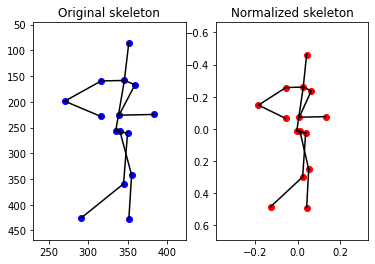

In [144]:
# Testing on single example

plot_humaneva(skeleton_2d_unnormalized[0][0])


### Alpha Pose Skeleton of the same Frame

In [145]:
import numpy as np

humaneva_2D = np.load('Alpha_Pose_HumanEva_2D_Unnormalize.npz',allow_pickle=True)
skeleton_2d=humaneva_2D['arr_0']

#Camera 1 
skeleton_2d.item()['Train/S1']['Box 1 chunk1'][0]

new_array=np.asarray([b.reshape(-1) for a in skeleton_2d.item()['Train/S1']['Jog 1 chunk1'] for b in a])
skeleton_2d_unnormalized=new_array.reshape(len(skeleton_2d.item()['Train/S1']['Jog 1 chunk3']),
                            int(new_array.shape[0]/3),
                            skeleton_2d.item()['Train/S1']['Walking 1 chunk0'][0][0].shape[0]*skeleton_2d.item()['Train/S1']['Box 1 chunk1'][0][0].shape[1])


In [146]:
humaneva_2D['arr_0'].item()['Train/S1'].keys()

dict_keys(['Box 1 chunk1', 'Box 1 chunk3', 'Box 1 chunk5', 'Box 1 chunk7', 'Gestures 1 chunk0', 'Jog 1 chunk1', 'Jog 1 chunk3', 'ThrowCatch 1 chunk1', 'Walking 1 chunk0'])

In [147]:
humaneva_2D['arr_0'].item()['Train/S1']['Box 1 chunk1'][0].shape

(29, 17, 2)

In [148]:
humaneva_example=skeleton_2d_unnormalized[0]
humaneva_norm=norm_alpha(humaneva_example)
humaneva_norm.shape

(91, 34)

In [149]:
humaneva_norm[0]

array([-0.0558924 , -0.31299752, -0.04639065, -0.33200092, -0.0558924 ,
       -0.32249921,  0.00111783, -0.32249921,  0.04862632, -0.33200092,
        0.02962295, -0.1704718 ,  0.03912469, -0.18947529,  0.02012132,
        0.01006064, -0.06539414, -0.17997354, -0.02738728,  0.1715897 ,
       -0.10340089, -0.30349581,  0.02012132,  0.13358284,  0.02962295,
        0.13358284,  0.03912469,  0.39012906,  0.03912469,  0.38062732,
        0.02962295,  0.6466751 ,  0.05812806,  0.59916673])

In [150]:
skeleton_2d_unnormalized.shape

(3, 91, 34)

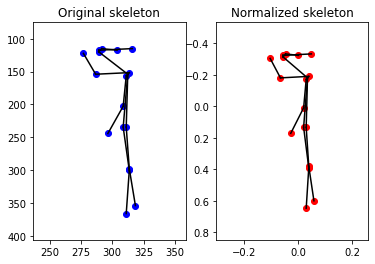

In [151]:
# Testing on single example

plot_alpha(skeleton_2d_unnormalized[0][0])


# Load HumanEva Skeleton Format and HumanEva AlphaPose Skeleton

In [34]:
import json 
import numpy as np
import torch
import pickle
from glob import glob


### Load Humaneva Alpha Pose from JSON

In [131]:
# Opening JSON file 
f = open('alphapose-results.json',) 
  
# returns JSON object as  
# a dictionary 
humaneva_json= json.load(f) 
  

# Closing file 
f.close() 

In [132]:
humaneva_json #Number of Frame

[{'image_id': '0.jpg',
  'category_id': 1,
  'keypoints': [292.39312744140625,
   112.99258422851562,
   0.8910728693008423,
   299.5730895996094,
   108.2059326171875,
   0.8862423300743103,
   287.6064758300781,
   108.2059326171875,
   0.906761884689331,
   306.7530822753906,
   112.99258422851562,
   0.8409406542778015,
   278.0331726074219,
   112.99258422851562,
   0.877068281173706,
   318.7196960449219,
   144.10580444335938,
   0.8836276531219482,
   266.0665588378906,
   146.49913024902344,
   0.8747820258140564,
   333.07965087890625,
   184.79232788085938,
   0.8983631730079651,
   256.4932556152344,
   184.79232788085938,
   0.6076288223266602,
   316.3263854980469,
   175.21902465820312,
   0.7818070650100708,
   258.8865966796875,
   175.21902465820312,
   0.7707027196884155,
   311.53973388671875,
   220.69219970703125,
   0.7582799792289734,
   280.426513671875,
   223.0855255126953,
   0.7809256911277771,
   318.7196960449219,
   287.705322265625,
   0.861937522888183

### Load Dictionary to Save and Normalize Alpha Pose Frame as .npz object

In [133]:
a_file = open("../Dataset/HumanEva-I/converted_15j/used_frame.pkl", "rb")
frame_used = pickle.load(a_file)
# print(frame_used)

In [134]:
len(humaneva_json)

28971

In [135]:
frame_used

{'S1': {'Box 1': [(395, 423, True, 'Train', 'Box 1 chunk1'),
   (437, 475, True, 'Train', 'Box 1 chunk3'),
   (500, 585, True, 'Train', 'Box 1 chunk5'),
   (692, 789, True, 'Train', 'Box 1 chunk7'),
   (5, 36, True, 'Validate', 'Box 1 chunk0'),
   (49, 181, True, 'Validate', 'Box 1 chunk2'),
   (213, 293, True, 'Validate', 'Box 1 chunk4'),
   (352, 358, True, 'Validate', 'Box 1 chunk6')],
  'Gestures 1': [(395, 801, True, 'Train', 'Gestures 1 chunk0'),
   (5, 395, True, 'Validate', 'Gestures 1 chunk0')],
  'Jog 1': [(601, 691, True, 'Train', 'Jog 1 chunk1'),
   (713, 740, True, 'Train', 'Jog 1 chunk3'),
   (5, 239, True, 'Validate', 'Jog 1 chunk0'),
   (270, 286, True, 'Validate', 'Jog 1 chunk2'),
   (297, 364, True, 'Validate', 'Jog 1 chunk4')],
  'ThrowCatch 1': [(712, 929, True, 'Train', 'ThrowCatch 1 chunk1')],
  'Walking 1': [(590, 1203, True, 'Train', 'Walking 1 chunk0'),
   (5, 18, True, 'Validate', 'Walking 1 chunk0'),
   (34, 193, True, 'Validate', 'Walking 1 chunk2'),
   (204

In [136]:
def create_npz_AlphaPose(dictionary,jsondata,normalize=False):
    frame_num=0
    main_dict={}

    for index,subject in enumerate(dictionary.keys()):
        for action in dictionary[subject]:
            for chunk in dictionary[subject][action]:
                third_dict={}
                action_ = action.replace(" ","_")
#                 print("\nSubject: ", subject)
#                 print("Action : ", chunk[4])
#                 print ("Frame :", chunk[:2])
#                 print ("What Data :", chunk[3])

                #Number of camera
                temp_camera_array=[]
                for a in range(0,3): 
                    #Each Frames in the camera
                    temp_frame_array=[]
                    for frame_index in  range(chunk[0],chunk[1]+1):
                        print(frame_num)

                        if(normalize):
                            #Turn on to normalize
                            temp_array=norm_alpha(np.asarray(data_converter(jsondata[frame_num])).reshape(1,34)).reshape(17,2)
                        else:
                            temp_array=np.asarray(data_converter(jsondata[frame_num])).reshape(17,2)
                        


                        temp_frame_array.append(temp_array)
                        frame_num=frame_num+1

                    temp_camera_array.append(np.asarray(temp_frame_array))

                third_dict[chunk[4]]=temp_camera_array
                try:
                    main_dict[chunk[3]+"/"+subject].update(third_dict)
                except KeyError:
                    main_dict[chunk[3]+"/"+subject] = third_dict

    humaneva_alpha=np.asarray(main_dict)
    
    if(normalize):
        np.savez_compressed("Alpha_Pose_HumanEva_2D_Normalize", humaneva_alpha)
    else:
        np.savez_compressed("Alpha_Pose_HumanEva_2D_Unnormalize", humaneva_alpha)
    
    return humaneva_alpha


In [137]:
create_npz_AlphaPose(frame_used,humaneva_json,True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575


4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354


6362
6363
6364
6365
6366
6367
6368
6369
6370
6371
6372
6373
6374
6375
6376
6377
6378
6379
6380
6381
6382
6383
6384
6385
6386
6387
6388
6389
6390
6391
6392
6393
6394
6395
6396
6397
6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
6415
6416
6417
6418
6419
6420
6421
6422
6423
6424
6425
6426
6427
6428
6429
6430
6431
6432
6433
6434
6435
6436
6437
6438
6439
6440
6441
6442
6443
6444
6445
6446
6447
6448
6449
6450
6451
6452
6453
6454
6455
6456
6457
6458
6459
6460
6461
6462
6463
6464
6465
6466
6467
6468
6469
6470
6471
6472
6473
6474
6475
6476
6477
6478
6479
6480
6481
6482
6483
6484
6485
6486
6487
6488
6489
6490
6491
6492
6493
6494
6495
6496
6497
6498
6499
6500
6501
6502
6503
6504
6505
6506
6507
6508
6509
6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539
6540
6541
6542
6543
6544
6545
6546
6547
6548
6549
6550
6551
6552
6553
6554
6555
6556
6557
6558
6559
6560
6561


8057
8058
8059
8060
8061
8062
8063
8064
8065
8066
8067
8068
8069
8070
8071
8072
8073
8074
8075
8076
8077
8078
8079
8080
8081
8082
8083
8084
8085
8086
8087
8088
8089
8090
8091
8092
8093
8094
8095
8096
8097
8098
8099
8100
8101
8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200
8201
8202
8203
8204
8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234
8235
8236
8237
8238
8239
8240
8241
8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255
8256


9780
9781
9782
9783
9784
9785
9786
9787
9788
9789
9790
9791
9792
9793
9794
9795
9796
9797
9798
9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816
9817
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9836
9837
9838
9839
9840
9841
9842
9843
9844
9845
9846
9847
9848
9849
9850
9851
9852
9853
9854
9855
9856
9857
9858
9859
9860
9861
9862
9863
9864
9865
9866
9867
9868
9869
9870
9871
9872
9873
9874
9875
9876
9877
9878
9879
9880
9881
9882
9883
9884
9885
9886
9887
9888
9889
9890
9891
9892
9893
9894
9895
9896
9897
9898
9899
9900
9901
9902
9903
9904
9905
9906
9907
9908
9909
9910
9911
9912
9913
9914
9915
9916
9917
9918
9919
9920
9921
9922
9923
9924
9925
9926
9927
9928
9929
9930
9931
9932
9933
9934
9935
9936
9937
9938
9939
9940
9941
9942
9943
9944
9945
9946
9947
9948
9949
9950
9951
9952
9953
9954
9955
9956
9957
9958
9959
9960
9961
9962
9963
9964
9965
9966
9967
9968
9969
9970
9971
9972
9973
9974
9975
9976
9977
9978
9979


11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
1171

13229
13230
13231
13232
13233
13234
13235
13236
13237
13238
13239
13240
13241
13242
13243
13244
13245
13246
13247
13248
13249
13250
13251
13252
13253
13254
13255
13256
13257
13258
13259
13260
13261
13262
13263
13264
13265
13266
13267
13268
13269
13270
13271
13272
13273
13274
13275
13276
13277
13278
13279
13280
13281
13282
13283
13284
13285
13286
13287
13288
13289
13290
13291
13292
13293
13294
13295
13296
13297
13298
13299
13300
13301
13302
13303
13304
13305
13306
13307
13308
13309
13310
13311
13312
13313
13314
13315
13316
13317
13318
13319
13320
13321
13322
13323
13324
13325
13326
13327
13328
13329
13330
13331
13332
13333
13334
13335
13336
13337
13338
13339
13340
13341
13342
13343
13344
13345
13346
13347
13348
13349
13350
13351
13352
13353
13354
13355
13356
13357
13358
13359
13360
13361
13362
13363
13364
13365
13366
13367
13368
13369
13370
13371
13372
13373
13374
13375
13376
13377
13378
13379
13380
13381
13382
13383
13384
13385
13386
13387
13388
13389
13390
13391
13392
13393
13394
1339

14946
14947
14948
14949
14950
14951
14952
14953
14954
14955
14956
14957
14958
14959
14960
14961
14962
14963
14964
14965
14966
14967
14968
14969
14970
14971
14972
14973
14974
14975
14976
14977
14978
14979
14980
14981
14982
14983
14984
14985
14986
14987
14988
14989
14990
14991
14992
14993
14994
14995
14996
14997
14998
14999
15000
15001
15002
15003
15004
15005
15006
15007
15008
15009
15010
15011
15012
15013
15014
15015
15016
15017
15018
15019
15020
15021
15022
15023
15024
15025
15026
15027
15028
15029
15030
15031
15032
15033
15034
15035
15036
15037
15038
15039
15040
15041
15042
15043
15044
15045
15046
15047
15048
15049
15050
15051
15052
15053
15054
15055
15056
15057
15058
15059
15060
15061
15062
15063
15064
15065
15066
15067
15068
15069
15070
15071
15072
15073
15074
15075
15076
15077
15078
15079
15080
15081
15082
15083
15084
15085
15086
15087
15088
15089
15090
15091
15092
15093
15094
15095
15096
15097
15098
15099
15100
15101
15102
15103
15104
15105
15106
15107
15108
15109
15110
15111
1511

16670
16671
16672
16673
16674
16675
16676
16677
16678
16679
16680
16681
16682
16683
16684
16685
16686
16687
16688
16689
16690
16691
16692
16693
16694
16695
16696
16697
16698
16699
16700
16701
16702
16703
16704
16705
16706
16707
16708
16709
16710
16711
16712
16713
16714
16715
16716
16717
16718
16719
16720
16721
16722
16723
16724
16725
16726
16727
16728
16729
16730
16731
16732
16733
16734
16735
16736
16737
16738
16739
16740
16741
16742
16743
16744
16745
16746
16747
16748
16749
16750
16751
16752
16753
16754
16755
16756
16757
16758
16759
16760
16761
16762
16763
16764
16765
16766
16767
16768
16769
16770
16771
16772
16773
16774
16775
16776
16777
16778
16779
16780
16781
16782
16783
16784
16785
16786
16787
16788
16789
16790
16791
16792
16793
16794
16795
16796
16797
16798
16799
16800
16801
16802
16803
16804
16805
16806
16807
16808
16809
16810
16811
16812
16813
16814
16815
16816
16817
16818
16819
16820
16821
16822
16823
16824
16825
16826
16827
16828
16829
16830
16831
16832
16833
16834
16835
1683

18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510
18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
18522
18523
18524
18525
18526
18527
18528
18529
18530
18531
18532
18533
18534
18535
1853

20042
20043
20044
20045
20046
20047
20048
20049
20050
20051
20052
20053
20054
20055
20056
20057
20058
20059
20060
20061
20062
20063
20064
20065
20066
20067
20068
20069
20070
20071
20072
20073
20074
20075
20076
20077
20078
20079
20080
20081
20082
20083
20084
20085
20086
20087
20088
20089
20090
20091
20092
20093
20094
20095
20096
20097
20098
20099
20100
20101
20102
20103
20104
20105
20106
20107
20108
20109
20110
20111
20112
20113
20114
20115
20116
20117
20118
20119
20120
20121
20122
20123
20124
20125
20126
20127
20128
20129
20130
20131
20132
20133
20134
20135
20136
20137
20138
20139
20140
20141
20142
20143
20144
20145
20146
20147
20148
20149
20150
20151
20152
20153
20154
20155
20156
20157
20158
20159
20160
20161
20162
20163
20164
20165
20166
20167
20168
20169
20170
20171
20172
20173
20174
20175
20176
20177
20178
20179
20180
20181
20182
20183
20184
20185
20186
20187
20188
20189
20190
20191
20192
20193
20194
20195
20196
20197
20198
20199
20200
20201
20202
20203
20204
20205
20206
20207
2020

21793
21794
21795
21796
21797
21798
21799
21800
21801
21802
21803
21804
21805
21806
21807
21808
21809
21810
21811
21812
21813
21814
21815
21816
21817
21818
21819
21820
21821
21822
21823
21824
21825
21826
21827
21828
21829
21830
21831
21832
21833
21834
21835
21836
21837
21838
21839
21840
21841
21842
21843
21844
21845
21846
21847
21848
21849
21850
21851
21852
21853
21854
21855
21856
21857
21858
21859
21860
21861
21862
21863
21864
21865
21866
21867
21868
21869
21870
21871
21872
21873
21874
21875
21876
21877
21878
21879
21880
21881
21882
21883
21884
21885
21886
21887
21888
21889
21890
21891
21892
21893
21894
21895
21896
21897
21898
21899
21900
21901
21902
21903
21904
21905
21906
21907
21908
21909
21910
21911
21912
21913
21914
21915
21916
21917
21918
21919
21920
21921
21922
21923
21924
21925
21926
21927
21928
21929
21930
21931
21932
21933
21934
21935
21936
21937
21938
21939
21940
21941
21942
21943
21944
21945
21946
21947
21948
21949
21950
21951
21952
21953
21954
21955
21956
21957
21958
2195

23547
23548
23549
23550
23551
23552
23553
23554
23555
23556
23557
23558
23559
23560
23561
23562
23563
23564
23565
23566
23567
23568
23569
23570
23571
23572
23573
23574
23575
23576
23577
23578
23579
23580
23581
23582
23583
23584
23585
23586
23587
23588
23589
23590
23591
23592
23593
23594
23595
23596
23597
23598
23599
23600
23601
23602
23603
23604
23605
23606
23607
23608
23609
23610
23611
23612
23613
23614
23615
23616
23617
23618
23619
23620
23621
23622
23623
23624
23625
23626
23627
23628
23629
23630
23631
23632
23633
23634
23635
23636
23637
23638
23639
23640
23641
23642
23643
23644
23645
23646
23647
23648
23649
23650
23651
23652
23653
23654
23655
23656
23657
23658
23659
23660
23661
23662
23663
23664
23665
23666
23667
23668
23669
23670
23671
23672
23673
23674
23675
23676
23677
23678
23679
23680
23681
23682
23683
23684
23685
23686
23687
23688
23689
23690
23691
23692
23693
23694
23695
23696
23697
23698
23699
23700
23701
23702
23703
23704
23705
23706
23707
23708
23709
23710
23711
23712
2371

25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346
25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358
25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
25369
25370
25371
25372
25373
25374
25375
25376
25377
25378
25379
25380
25381
25382
25383
25384
25385
25386
25387
25388
25389
25390
25391
25392
25393
25394
25395
25396
25397
25398
25399
25400
25401
25402
25403
25404
25405
25406
25407
25408
25409
25410
25411
25412
25413
25414
25415
25416
25417
25418
25419
25420
25421
25422
25423
25424
25425
25426
25427
25428
25429
25430
25431
25432
25433
25434
25435
25436
25437
25438
25439
25440
25441
25442
25443
25444
25445
25446
25447
25448
25449
25450
25451
25452
25453
25454
25455
25456
25457
25458
2545

27082
27083
27084
27085
27086
27087
27088
27089
27090
27091
27092
27093
27094
27095
27096
27097
27098
27099
27100
27101
27102
27103
27104
27105
27106
27107
27108
27109
27110
27111
27112
27113
27114
27115
27116
27117
27118
27119
27120
27121
27122
27123
27124
27125
27126
27127
27128
27129
27130
27131
27132
27133
27134
27135
27136
27137
27138
27139
27140
27141
27142
27143
27144
27145
27146
27147
27148
27149
27150
27151
27152
27153
27154
27155
27156
27157
27158
27159
27160
27161
27162
27163
27164
27165
27166
27167
27168
27169
27170
27171
27172
27173
27174
27175
27176
27177
27178
27179
27180
27181
27182
27183
27184
27185
27186
27187
27188
27189
27190
27191
27192
27193
27194
27195
27196
27197
27198
27199
27200
27201
27202
27203
27204
27205
27206
27207
27208
27209
27210
27211
27212
27213
27214
27215
27216
27217
27218
27219
27220
27221
27222
27223
27224
27225
27226
27227
27228
27229
27230
27231
27232
27233
27234
27235
27236
27237
27238
27239
27240
27241
27242
27243
27244
27245
27246
27247
2724

28867
28868
28869
28870
28871
28872
28873
28874
28875
28876
28877
28878
28879
28880
28881
28882
28883
28884
28885
28886
28887
28888
28889
28890
28891
28892
28893
28894
28895
28896
28897
28898
28899
28900
28901
28902
28903
28904
28905
28906
28907
28908
28909
28910
28911
28912
28913
28914
28915
28916
28917
28918
28919
28920
28921
28922
28923
28924
28925
28926
28927
28928
28929
28930
28931
28932
28933
28934
28935
28936
28937
28938
28939
28940
28941
28942
28943
28944
28945
28946
28947
28948
28949
28950
28951
28952
28953
28954
28955
28956
28957
28958
28959
28960
28961


array({'Train/S1': {'Box 1 chunk1': [array([[[-1.06542480e-02, -3.20187972e-01],
        [ 1.79439263e-02, -3.39253462e-01],
        [-2.97197381e-02, -3.39253462e-01],
        [ 4.65422221e-02, -3.20187972e-01],
        [-6.78507182e-02, -3.20187972e-01],
        [ 9.42058865e-02, -1.96262348e-01],
        [-1.15514383e-01, -1.86729603e-01],
        [ 1.51402357e-01, -3.42057429e-02],
        [-1.53645363e-01, -3.42057429e-02],
        [ 8.46732022e-02, -7.23367230e-02],
        [-1.44112557e-01, -7.23367230e-02],
        [ 6.56077122e-02,  1.08785372e-01],
        [-5.83179124e-02,  1.18318117e-01],
        [ 9.42058865e-02,  3.75702232e-01],
        [-5.83179124e-02,  3.75702232e-01],
        [ 1.13271377e-01,  6.42618972e-01],
        [-2.97197381e-02,  6.14020797e-01]],

       [[-1.56156803e-02, -3.25140168e-01],
        [ 1.28271746e-02, -3.44102031e-01],
        [-3.45775432e-02, -3.44102031e-01],
        [ 5.07509004e-02, -3.25140168e-01],
        [-6.30202770e-02, -3.25140168

In [138]:
create_npz_AlphaPose(frame_used,humaneva_json,False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

3909
3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108


7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
7833
7834
7835
7836
7837
7838
7839
7840
7841
7842
7843
7844
7845
7846
7847
7848
7849
7850
7851
7852
7853
7854
7855
7856
7857
7858
7859
7860
7861
7862
7863
7864
7865
7866
7867
7868
7869
7870
7871
7872
7873
7874
7875
7876
7877
7878
7879
7880
7881
7882
7883
7884
7885
7886
7887
7888
7889
7890
7891
7892
7893
7894
7895
7896
7897
7898
7899
7900
7901
7902
7903
7904
7905
7906
7907
7908
7909
7910
7911
7912
7913
7914
7915
7916
7917
7918
7919
7920
7921


11384
11385
11386
11387
11388
11389
11390
11391
11392
11393
11394
11395
11396
11397
11398
11399
11400
11401
11402
11403
11404
11405
11406
11407
11408
11409
11410
11411
11412
11413
11414
11415
11416
11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
1155

14879
14880
14881
14882
14883
14884
14885
14886
14887
14888
14889
14890
14891
14892
14893
14894
14895
14896
14897
14898
14899
14900
14901
14902
14903
14904
14905
14906
14907
14908
14909
14910
14911
14912
14913
14914
14915
14916
14917
14918
14919
14920
14921
14922
14923
14924
14925
14926
14927
14928
14929
14930
14931
14932
14933
14934
14935
14936
14937
14938
14939
14940
14941
14942
14943
14944
14945
14946
14947
14948
14949
14950
14951
14952
14953
14954
14955
14956
14957
14958
14959
14960
14961
14962
14963
14964
14965
14966
14967
14968
14969
14970
14971
14972
14973
14974
14975
14976
14977
14978
14979
14980
14981
14982
14983
14984
14985
14986
14987
14988
14989
14990
14991
14992
14993
14994
14995
14996
14997
14998
14999
15000
15001
15002
15003
15004
15005
15006
15007
15008
15009
15010
15011
15012
15013
15014
15015
15016
15017
15018
15019
15020
15021
15022
15023
15024
15025
15026
15027
15028
15029
15030
15031
15032
15033
15034
15035
15036
15037
15038
15039
15040
15041
15042
15043
15044
1504

18581
18582
18583
18584
18585
18586
18587
18588
18589
18590
18591
18592
18593
18594
18595
18596
18597
18598
18599
18600
18601
18602
18603
18604
18605
18606
18607
18608
18609
18610
18611
18612
18613
18614
18615
18616
18617
18618
18619
18620
18621
18622
18623
18624
18625
18626
18627
18628
18629
18630
18631
18632
18633
18634
18635
18636
18637
18638
18639
18640
18641
18642
18643
18644
18645
18646
18647
18648
18649
18650
18651
18652
18653
18654
18655
18656
18657
18658
18659
18660
18661
18662
18663
18664
18665
18666
18667
18668
18669
18670
18671
18672
18673
18674
18675
18676
18677
18678
18679
18680
18681
18682
18683
18684
18685
18686
18687
18688
18689
18690
18691
18692
18693
18694
18695
18696
18697
18698
18699
18700
18701
18702
18703
18704
18705
18706
18707
18708
18709
18710
18711
18712
18713
18714
18715
18716
18717
18718
18719
18720
18721
18722
18723
18724
18725
18726
18727
18728
18729
18730
18731
18732
18733
18734
18735
18736
18737
18738
18739
18740
18741
18742
18743
18744
18745
18746
1874

22117
22118
22119
22120
22121
22122
22123
22124
22125
22126
22127
22128
22129
22130
22131
22132
22133
22134
22135
22136
22137
22138
22139
22140
22141
22142
22143
22144
22145
22146
22147
22148
22149
22150
22151
22152
22153
22154
22155
22156
22157
22158
22159
22160
22161
22162
22163
22164
22165
22166
22167
22168
22169
22170
22171
22172
22173
22174
22175
22176
22177
22178
22179
22180
22181
22182
22183
22184
22185
22186
22187
22188
22189
22190
22191
22192
22193
22194
22195
22196
22197
22198
22199
22200
22201
22202
22203
22204
22205
22206
22207
22208
22209
22210
22211
22212
22213
22214
22215
22216
22217
22218
22219
22220
22221
22222
22223
22224
22225
22226
22227
22228
22229
22230
22231
22232
22233
22234
22235
22236
22237
22238
22239
22240
22241
22242
22243
22244
22245
22246
22247
22248
22249
22250
22251
22252
22253
22254
22255
22256
22257
22258
22259
22260
22261
22262
22263
22264
22265
22266
22267
22268
22269
22270
22271
22272
22273
22274
22275
22276
22277
22278
22279
22280
22281
22282
2228

25880
25881
25882
25883
25884
25885
25886
25887
25888
25889
25890
25891
25892
25893
25894
25895
25896
25897
25898
25899
25900
25901
25902
25903
25904
25905
25906
25907
25908
25909
25910
25911
25912
25913
25914
25915
25916
25917
25918
25919
25920
25921
25922
25923
25924
25925
25926
25927
25928
25929
25930
25931
25932
25933
25934
25935
25936
25937
25938
25939
25940
25941
25942
25943
25944
25945
25946
25947
25948
25949
25950
25951
25952
25953
25954
25955
25956
25957
25958
25959
25960
25961
25962
25963
25964
25965
25966
25967
25968
25969
25970
25971
25972
25973
25974
25975
25976
25977
25978
25979
25980
25981
25982
25983
25984
25985
25986
25987
25988
25989
25990
25991
25992
25993
25994
25995
25996
25997
25998
25999
26000
26001
26002
26003
26004
26005
26006
26007
26008
26009
26010
26011
26012
26013
26014
26015
26016
26017
26018
26019
26020
26021
26022
26023
26024
26025
26026
26027
26028
26029
26030
26031
26032
26033
26034
26035
26036
26037
26038
26039
26040
26041
26042
26043
26044
26045
2604

array({'Train/S1': {'Box 1 chunk1': [array([[[292.39312744, 112.99258423],
        [299.5730896 , 108.20593262],
        [287.60647583, 108.20593262],
        [306.75308228, 112.99258423],
        [278.03317261, 112.99258423],
        [318.71969604, 144.10580444],
        [266.06655884, 146.49913025],
        [333.07965088, 184.79232788],
        [256.49325562, 184.79232788],
        [316.3263855 , 175.21902466],
        [258.88659668, 175.21902466],
        [311.53973389, 220.69219971],
        [280.42651367, 223.08552551],
        [318.71969604, 287.70532227],
        [280.42651367, 287.70532227],
        [323.50634766, 354.71841431],
        [287.60647583, 347.53845215]],

       [[290.70254517, 111.53569031],
        [297.87091064, 106.75679016],
        [285.92364502, 106.75679016],
        [307.42871094, 111.53569031],
        [278.75531006, 111.53569031],
        [319.37594604, 144.98799133],
        [266.80804443, 147.37745667],
        [333.71264648, 183.2191925 ],
        [25

## Load Human Eva Original from NPZ

In [37]:
humaneva_2D = np.load('../Dataset/HumanEva-I/converted_15j/data_2d_humaneva15_gt.npz',allow_pickle=True)
humaneva_original=humaneva_2D['positions_2d']

In [483]:
humaneva_original.item()['Train/S1'].keys()

dict_keys(['Box 1 chunk1', 'Box 1 chunk3', 'Box 1 chunk5', 'Box 1 chunk7', 'Gestures 1 chunk0', 'Jog 1 chunk1', 'Jog 1 chunk3', 'ThrowCatch 1 chunk1', 'Walking 1 chunk0'])

In [484]:
#2D Items
print("Subjects: ",humaneva_original.item().keys())
print("\nNumber of Action: ",humaneva_original.item()['Train/S1'].keys())
print("\nNumber of camera: ",len(humaneva_original.item()['Train/S1']['Box 1 chunk1']))
print("\nNumber of frame in Camera: ",len(humaneva_original.item()['Train/S1']['Box 1 chunk1'][0]))
print("\nSkeleton information in one frame: ",humaneva_original.item()['Train/S1']['Box 1 chunk1'][0][0].shape)

Subjects:  dict_keys(['Train/S1', 'Train/S2', 'Train/S3', 'Validate/S1', 'Validate/S2', 'Validate/S3'])

Number of Action:  dict_keys(['Box 1 chunk1', 'Box 1 chunk3', 'Box 1 chunk5', 'Box 1 chunk7', 'Gestures 1 chunk0', 'Jog 1 chunk1', 'Jog 1 chunk3', 'ThrowCatch 1 chunk1', 'Walking 1 chunk0'])

Number of camera:  3

Number of frame in Camera:  28

Skeleton information in one frame:  (15, 2)


Total Frames:  28962.0


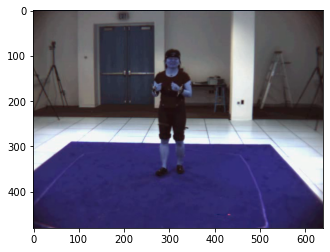

In [85]:
import cv2 
from matplotlib import pyplot as plt

myFrameNumber = 28
cap = cv2.VideoCapture("all.avi")

# get total number of frames
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print("Total Frames: ", totalFrames)
# check for valid frame number
if myFrameNumber >= 0 & myFrameNumber <= totalFrames:
    # set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES,myFrameNumber)

while True:
    ret, frame = cap.read()
    plt.imshow(frame)
    plt.show() 
    break

